## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from Common import NeuralNet

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

Consider the one-dimensional heat equation:

$$
u_t(t, x) = k(t,x)u_{xx}(t, x) + s(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0, 
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

The equation parameter $k:[0,T]\times[-1,1]\mapsto \mathbb{R} $ denotes the medium conductivity and $s:[0,T]\times[-1,1]\mapsto \mathbb{R}$ is a source term.

We want to solve a parameter identification inverse problem, which can be formulated as follows:

*given observation measurements of the medium temperature $S_{meas}=\{(t_i, x_i, u^{meas}_{i})\}_{i=1}^{N_{meas}}$, find $u: [0,T]\times[-1,1]\mapsto\mathbb{R}$ and $k:[-1,1]\mapsto \mathbb{R}$, such that $u_t(t, x) = k(t,x)u_{xx}(t, x) + s(t,x)$, $u_b(t, -1)=u_b(t,1)=0, $ and $u(x, 0) = u_0(x) = -\sin(\pi x)$*



To do so, we approximate the underlying solution and the medium conductivity with two feedforward dense neural network with tunable parameters $\theta$ and $\phi$:

$$
u_\theta(t,x) \approx u(t,x), \quad k_\phi(t, x) \approx k(t, x) 
$$
To do so, define the following residuals:

   - Interior residual given by,
   $$r_{int,\theta, \phi}(t, x):=  u_{\theta, t}(t, x) - k_\phi(t,x)u_{\theta, xx}(t, x) -s(t,x), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   

        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta, \phi) = \int_{[0,T]\times[-1,1]}r_{int,\theta, \phi}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad 1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences:

$$
L_{int}(\theta, \phi) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta,\phi}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

Also the measurements data $S_{meas}$ have to taken into account. To do so, we define ad additional loss term:
$$
L_{meas} = \frac{1}{N_{meas}}\sum_{i=1}^{N_{mean}}(u_\theta(t_i, x_i) - u^{meas}_i)^2(x_n)
$$
and eventually solve the following minimization problem

$$
\theta^\ast, \phi^\ast = argmin_{\theta, \phi} \Big(L_{int}(\theta, \phi) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta) + L_{meas}(\theta)
$$


In the following let's assume

$$u_{ex}(t,x) = -\exp(-\pi^2 t)\sin(\pi x), \quad k(t,x)=k(x)=\sin(\pi x).$$

Then, the source term $s$ can be computed by plugging the expression above in the PDE:

$$
s(t,x) = -\pi^2u_{ex}(t,x)*(1 - k(t,x))
$$

Moreover, let us assume that the measurments data are given as follows:

$$
u_{meas}(x_i, t_i) = u_{ex}(x_i t_i) + 0.01\xi, \quad \xi \sim \mathcal{N(0, 1)}
$$

where $\mathcal{N(0, 1)}$ is a standard normal distribution.



In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_


        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)

        # FF Dense NN to approximate the conductivity we wish to infer
        self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                                 n_hidden_layers=4,
                                                 neurons=20,
                                                 regularization_param=0.,
                                                 regularization_exp=2.,
                                                 retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

        # number of sensors to record temperature
        self.n_sensor = 50

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    def exact_conductivity(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]
        k = (torch.sin(np.pi * x) + 1.1)

        return k


    def source(self, inputs):

        s = -np.pi**2*self.exact_solution(inputs)*(1 - self.exact_conductivity(inputs))
        return s

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int
    

    def get_measurement_data(self):
        torch.random.manual_seed(42)
        # take measurments every 0.001 sec on a set of randomly placed (in space) sensors
        t = torch.linspace(0, self.domain_extrema[0, 1], 25)
        x = torch.linspace(self.domain_extrema[1, 0], self.domain_extrema[1, 1], self.n_sensor)


        input_meas = torch.cartesian_prod(t, x)

        output_meas = self.exact_solution(input_meas).reshape(-1,1)
        noise = 0.01*torch.randn_like(output_meas)
        output_meas = output_meas + noise

        return input_meas, output_meas



    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb


    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int).reshape(-1,)
        k = self.approximate_coefficient(input_int).reshape(-1,)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]


        s = self.source(input_int)


        residual = grad_u_t - k*grad_u_xx - s

        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        inp_train_meas, u_train_meas = self.get_measurement_data()
        u_pred_meas = self.approximate_solution(inp_train_meas)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_train_meas - u_pred_meas

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_u = loss_sb + loss_tb + loss_meas

        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm U: ", err.item(), "%")

        approximate_conductivity = self.approximate_coefficient(inputs).reshape(-1, )
        exact_conductivity = self.exact_conductivity(inputs).reshape(-1, )


        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_conductivity.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=approximate_conductivity.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Conductivity")
        axs[1].set_title("Approximate Conductivity")

        err = (torch.mean((approximate_conductivity - exact_conductivity) ** 2) / torch.mean(exact_conductivity ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm K: ", err.item(), "%")

        plt.show()




In [3]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

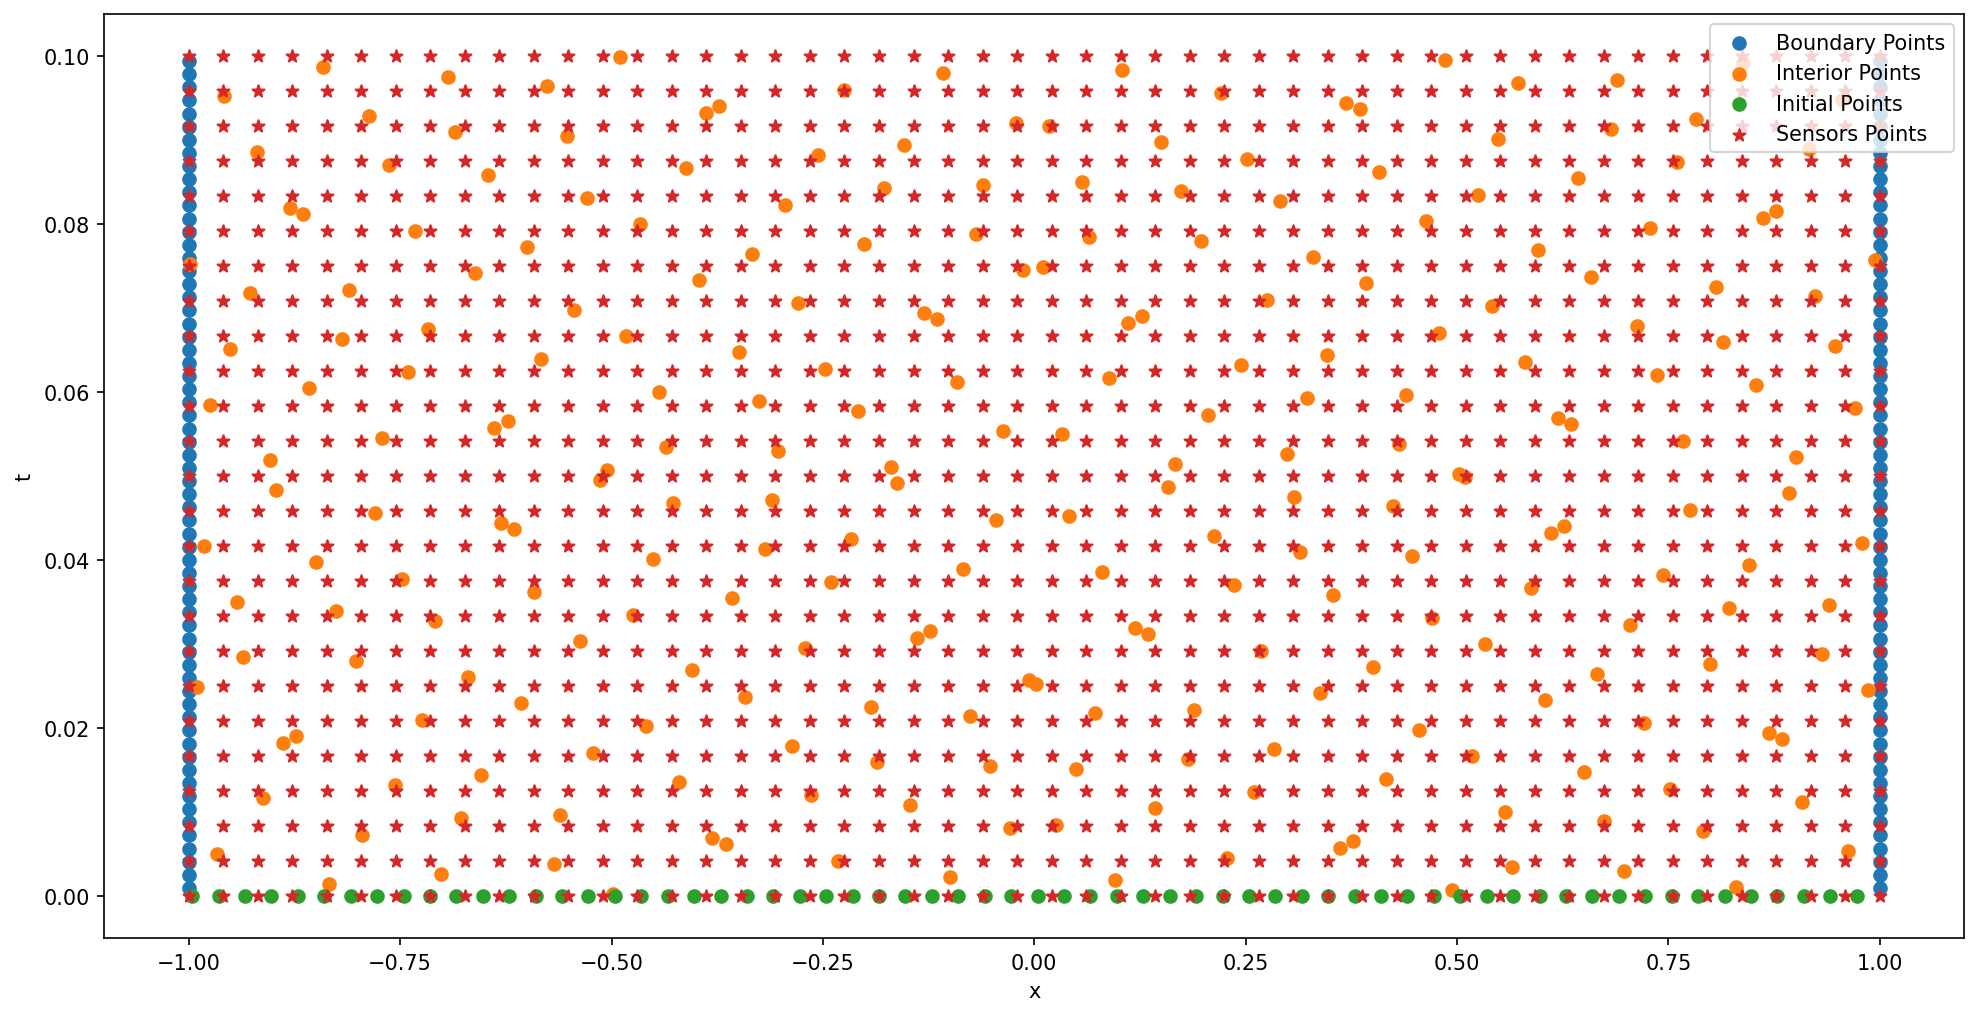

In [4]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_, output_meas_ = pinn.get_measurement_data()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_meas_[:, 1].detach().numpy(), input_meas_[:, 0].detach().numpy(), label="Sensors Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [5]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.5),
                              max_iter=1000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

################################  0  ################################
Total loss:  1.9527 | PDE Loss:  1.8761 | Function Loss:  0.1619
Total loss:  1.9061 | PDE Loss:  1.8385 | Function Loss:  0.0651
Total loss:  1.521 | PDE Loss:  1.3634 | Function Loss:  0.0043
Total loss:  1.6588 | PDE Loss:  0.7416 | Function Loss:  0.6028
Total loss:  1.4441 | PDE Loss:  1.0571 | Function Loss:  0.2148
Total loss:  1.3283 | PDE Loss:  0.9053 | Function Loss:  0.1223
Total loss:  1.0768 | PDE Loss:  0.7615 | Function Loss:  -0.2104
Total loss:  0.9578 | PDE Loss:  0.6288 | Function Loss:  -0.317
Total loss:  0.9077 | PDE Loss:  0.5676 | Function Loss:  -0.3576
Total loss:  0.8718 | PDE Loss:  0.5121 | Function Loss:  -0.3775
Total loss:  0.8571 | PDE Loss:  0.4938 | Function Loss:  -0.3895
Total loss:  0.8437 | PDE Loss:  0.4778 | Function Loss:  -0.4009
Total loss:  0.8078 | PDE Loss:  0.4427 | Function Loss:  -0.4374
Total loss:  0.7239 | PDE Loss:  0.4145 | Function Loss:  -0.5689
Total loss:  0

Total loss:  -0.9213 | PDE Loss:  -1.4179 | Function Loss:  -2.0879
Total loss:  -0.9283 | PDE Loss:  -1.4104 | Function Loss:  -2.1019
Total loss:  -0.9359 | PDE Loss:  -1.4323 | Function Loss:  -2.1026
Total loss:  -0.9466 | PDE Loss:  -1.465 | Function Loss:  -2.1034
Total loss:  -0.9598 | PDE Loss:  -1.5146 | Function Loss:  -2.1017
Total loss:  -0.9712 | PDE Loss:  -1.5357 | Function Loss:  -2.1094
Total loss:  -0.9866 | PDE Loss:  -1.5502 | Function Loss:  -2.1252
Total loss:  -1.0031 | PDE Loss:  -1.5554 | Function Loss:  -2.146
Total loss:  -1.0173 | PDE Loss:  -1.5528 | Function Loss:  -2.1668
Total loss:  -1.0284 | PDE Loss:  -1.5507 | Function Loss:  -2.1836
Total loss:  -1.043 | PDE Loss:  -1.5255 | Function Loss:  -2.2165
Total loss:  -1.0616 | PDE Loss:  -1.5181 | Function Loss:  -2.2484
Total loss:  -1.0789 | PDE Loss:  -1.5107 | Function Loss:  -2.2795
Total loss:  -1.0988 | PDE Loss:  -1.5153 | Function Loss:  -2.3087
Total loss:  -1.1091 | PDE Loss:  -1.5148 | Functio

Total loss:  -1.8539 | PDE Loss:  -2.3027 | Function Loss:  -3.0449
Total loss:  -1.8572 | PDE Loss:  -2.3036 | Function Loss:  -3.0495
Total loss:  -1.8598 | PDE Loss:  -2.2967 | Function Loss:  -3.0575
Total loss:  -1.8633 | PDE Loss:  -2.3021 | Function Loss:  -3.06
Total loss:  -1.8667 | PDE Loss:  -2.3085 | Function Loss:  -3.0616
Total loss:  -1.8702 | PDE Loss:  -2.3087 | Function Loss:  -3.0669
Total loss:  -1.8753 | PDE Loss:  -2.3128 | Function Loss:  -3.0726
Total loss:  -1.8822 | PDE Loss:  -2.316 | Function Loss:  -3.0817
Total loss:  -1.8919 | PDE Loss:  -2.3201 | Function Loss:  -3.0947
Total loss:  -1.902 | PDE Loss:  -2.3355 | Function Loss:  -3.1017
Total loss:  -1.9111 | PDE Loss:  -2.3403 | Function Loss:  -3.1132
Total loss:  -1.9206 | PDE Loss:  -2.3594 | Function Loss:  -3.1171
Total loss:  -1.9247 | PDE Loss:  -2.3529 | Function Loss:  -3.1275
Total loss:  -1.9283 | PDE Loss:  -2.3664 | Function Loss:  -3.1253
Total loss:  -1.931 | PDE Loss:  -2.3743 | Function 

Total loss:  -2.4058 | PDE Loss:  -3.0675 | Function Loss:  -3.5126
Total loss:  -2.4098 | PDE Loss:  -3.0722 | Function Loss:  -3.5163
Total loss:  -2.4131 | PDE Loss:  -3.0781 | Function Loss:  -3.519
Total loss:  -2.4155 | PDE Loss:  -3.0777 | Function Loss:  -3.5221
Total loss:  -2.4169 | PDE Loss:  -3.0872 | Function Loss:  -3.5213
Total loss:  -2.4177 | PDE Loss:  -3.0824 | Function Loss:  -3.5236
Total loss:  -2.4182 | PDE Loss:  -3.0841 | Function Loss:  -3.5238
Total loss:  -2.4189 | PDE Loss:  -3.0863 | Function Loss:  -3.524
Total loss:  -2.4196 | PDE Loss:  -3.0894 | Function Loss:  -3.5242
Total loss:  -2.4207 | PDE Loss:  -3.0921 | Function Loss:  -3.5248
Total loss:  -2.4223 | PDE Loss:  -3.095 | Function Loss:  -3.5261
Total loss:  -2.4245 | PDE Loss:  -3.0963 | Function Loss:  -3.5285
Total loss:  -2.4274 | PDE Loss:  -3.095 | Function Loss:  -3.5326
Total loss:  -2.4302 | PDE Loss:  -3.0908 | Function Loss:  -3.5373
Total loss:  -2.4328 | PDE Loss:  -3.088 | Function 

Total loss:  -2.6378 | PDE Loss:  -3.1989 | Function Loss:  -3.7773
Total loss:  -2.6381 | PDE Loss:  -3.1966 | Function Loss:  -3.7786
Total loss:  -2.6384 | PDE Loss:  -3.196 | Function Loss:  -3.7793
Total loss:  -2.6387 | PDE Loss:  -3.1947 | Function Loss:  -3.7801
Total loss:  -2.6389 | PDE Loss:  -3.195 | Function Loss:  -3.7804
Total loss:  -2.6392 | PDE Loss:  -3.1953 | Function Loss:  -3.7806
Total loss:  -2.6395 | PDE Loss:  -3.1959 | Function Loss:  -3.7808
Total loss:  -2.64 | PDE Loss:  -3.1971 | Function Loss:  -3.781
Total loss:  -2.6409 | PDE Loss:  -3.1976 | Function Loss:  -3.782
Total loss:  -2.6423 | PDE Loss:  -3.1991 | Function Loss:  -3.7834
Total loss:  -2.6445 | PDE Loss:  -3.1978 | Function Loss:  -3.787
Total loss:  -2.6478 | PDE Loss:  -3.1989 | Function Loss:  -3.7911
Total loss:  -2.6504 | PDE Loss:  -3.1923 | Function Loss:  -3.7974
Total loss:  -2.654 | PDE Loss:  -3.1937 | Function Loss:  -3.8019
Total loss:  -2.6562 | PDE Loss:  -3.1933 | Function Los

Total loss:  -2.7623 | PDE Loss:  -3.3731 | Function Loss:  -3.8843
Total loss:  -2.7629 | PDE Loss:  -3.3732 | Function Loss:  -3.8851
Total loss:  -2.7637 | PDE Loss:  -3.3722 | Function Loss:  -3.8865
Total loss:  -2.7646 | PDE Loss:  -3.3711 | Function Loss:  -3.8881
Total loss:  -2.7657 | PDE Loss:  -3.369 | Function Loss:  -3.8902
Total loss:  -2.7672 | PDE Loss:  -3.3666 | Function Loss:  -3.8931
Total loss:  -2.7677 | PDE Loss:  -3.359 | Function Loss:  -3.8963
Total loss:  -2.7681 | PDE Loss:  -3.363 | Function Loss:  -3.8954
Total loss:  -2.7691 | PDE Loss:  -3.3629 | Function Loss:  -3.8968
Total loss:  -2.7713 | PDE Loss:  -3.3647 | Function Loss:  -3.8991
Total loss:  -2.7735 | PDE Loss:  -3.3675 | Function Loss:  -3.9011
Total loss:  -2.7667 | PDE Loss:  -3.3295 | Function Loss:  -3.9055
Total loss:  -2.7745 | PDE Loss:  -3.3661 | Function Loss:  -3.903
Total loss:  -2.7762 | PDE Loss:  -3.3714 | Function Loss:  -3.9034
Total loss:  -2.7782 | PDE Loss:  -3.3777 | Function

Total loss:  -2.8434 | PDE Loss:  -3.5694 | Function Loss:  -3.9337
Total loss:  -2.8436 | PDE Loss:  -3.5702 | Function Loss:  -3.9338
Total loss:  -2.8438 | PDE Loss:  -3.5713 | Function Loss:  -3.9339
Total loss:  -2.8442 | PDE Loss:  -3.573 | Function Loss:  -3.934
Total loss:  -2.8447 | PDE Loss:  -3.575 | Function Loss:  -3.9342
Total loss:  -2.8455 | PDE Loss:  -3.5785 | Function Loss:  -3.9343
Total loss:  -2.8462 | PDE Loss:  -3.58 | Function Loss:  -3.9348
Total loss:  -2.8472 | PDE Loss:  -3.5814 | Function Loss:  -3.9357
Total loss:  -2.8479 | PDE Loss:  -3.5817 | Function Loss:  -3.9365
Total loss:  -2.8486 | PDE Loss:  -3.5834 | Function Loss:  -3.937
Total loss:  -2.8493 | PDE Loss:  -3.5835 | Function Loss:  -3.9378
Total loss:  -2.8497 | PDE Loss:  -3.5846 | Function Loss:  -3.9381
Total loss:  -2.85 | PDE Loss:  -3.5876 | Function Loss:  -3.9378
Total loss:  -2.8505 | PDE Loss:  -3.5912 | Function Loss:  -3.9375
Total loss:  -2.851 | PDE Loss:  -3.5961 | Function Loss

Total loss:  -2.911 | PDE Loss:  -3.9051 | Function Loss:  -3.9574
Total loss:  -2.9112 | PDE Loss:  -3.9022 | Function Loss:  -3.958
Total loss:  -2.9117 | PDE Loss:  -3.9028 | Function Loss:  -3.9584
Total loss:  -2.9121 | PDE Loss:  -3.9037 | Function Loss:  -3.9588
Total loss:  -2.9125 | PDE Loss:  -3.9044 | Function Loss:  -3.9592
Total loss:  -2.913 | PDE Loss:  -3.9066 | Function Loss:  -3.9594
Total loss:  -2.9134 | PDE Loss:  -3.9101 | Function Loss:  -3.9595
Total loss:  -2.9139 | PDE Loss:  -3.9141 | Function Loss:  -3.9596
Total loss:  -2.9141 | PDE Loss:  -3.9147 | Function Loss:  -3.9597
Total loss:  -2.9145 | PDE Loss:  -3.9204 | Function Loss:  -3.9596
Total loss:  -2.9147 | PDE Loss:  -3.9218 | Function Loss:  -3.9597
Total loss:  -2.9149 | PDE Loss:  -3.9239 | Function Loss:  -3.9597
Total loss:  -2.9151 | PDE Loss:  -3.925 | Function Loss:  -3.9598
Total loss:  -2.9153 | PDE Loss:  -3.9269 | Function Loss:  -3.9598
Total loss:  -2.9154 | PDE Loss:  -3.9278 | Function

Total loss:  -2.9444 | PDE Loss:  -4.1583 | Function Loss:  -3.9717
Total loss:  -2.9445 | PDE Loss:  -4.1599 | Function Loss:  -3.9718
Total loss:  -2.9446 | PDE Loss:  -4.1617 | Function Loss:  -3.9717
Total loss:  -2.9447 | PDE Loss:  -4.164 | Function Loss:  -3.9717
Total loss:  -2.9448 | PDE Loss:  -4.1666 | Function Loss:  -3.9717
Total loss:  -2.945 | PDE Loss:  -4.1689 | Function Loss:  -3.9717
Total loss:  -2.9451 | PDE Loss:  -4.1711 | Function Loss:  -3.9717
Total loss:  -2.9453 | PDE Loss:  -4.1732 | Function Loss:  -3.9718
Total loss:  -2.9454 | PDE Loss:  -4.1749 | Function Loss:  -3.9718
Total loss:  -2.9455 | PDE Loss:  -4.1763 | Function Loss:  -3.9719
Total loss:  -2.9457 | PDE Loss:  -4.177 | Function Loss:  -3.9719
Final Loss:  -2.9456512928009033


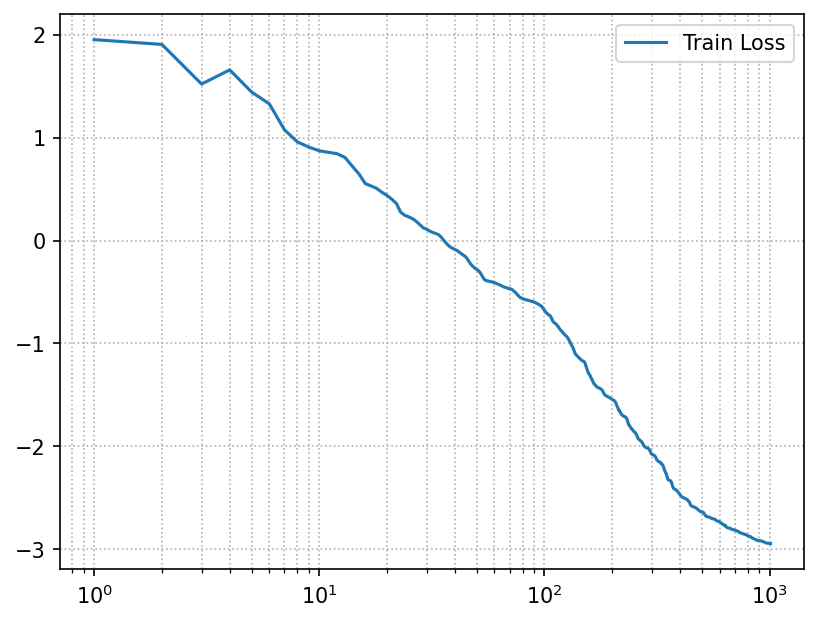

In [6]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

L2 Relative Error Norm U:  0.5184507966041565 %
L2 Relative Error Norm K:  7.460681915283203 %


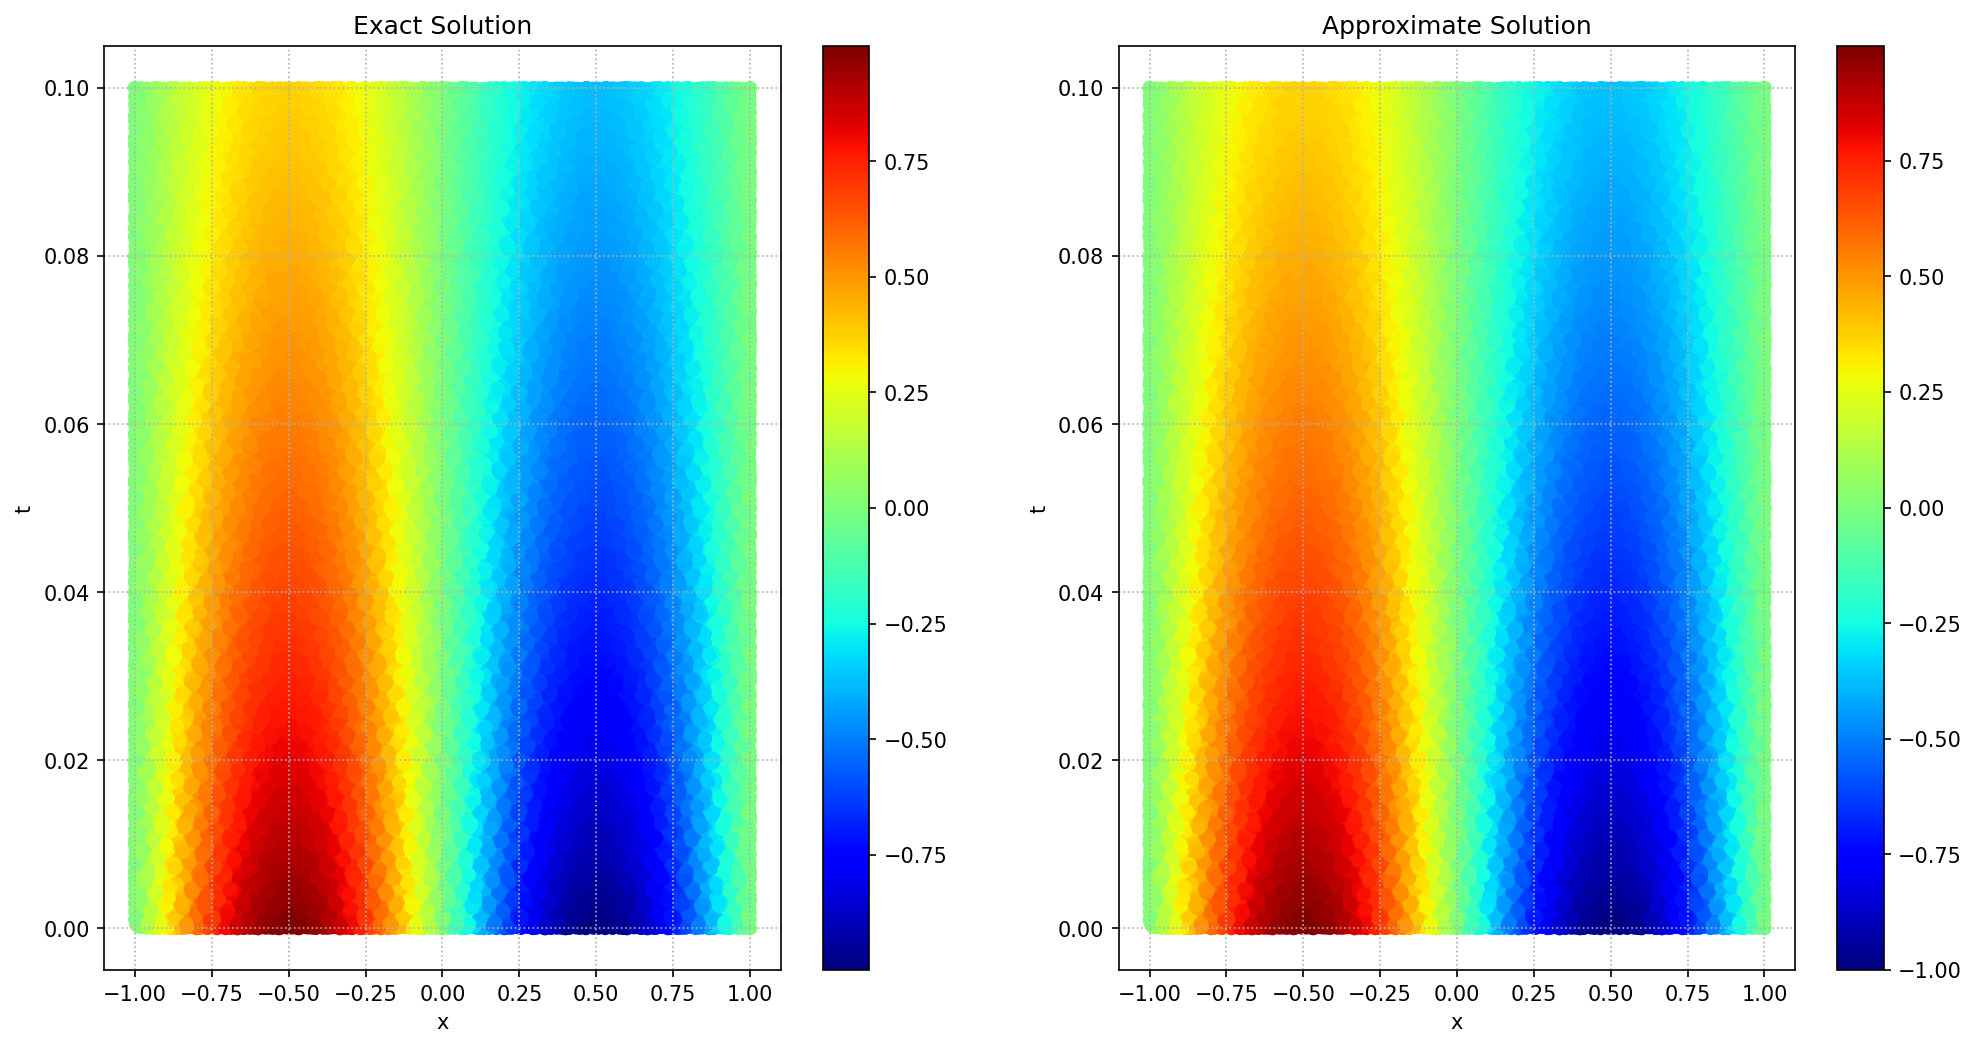

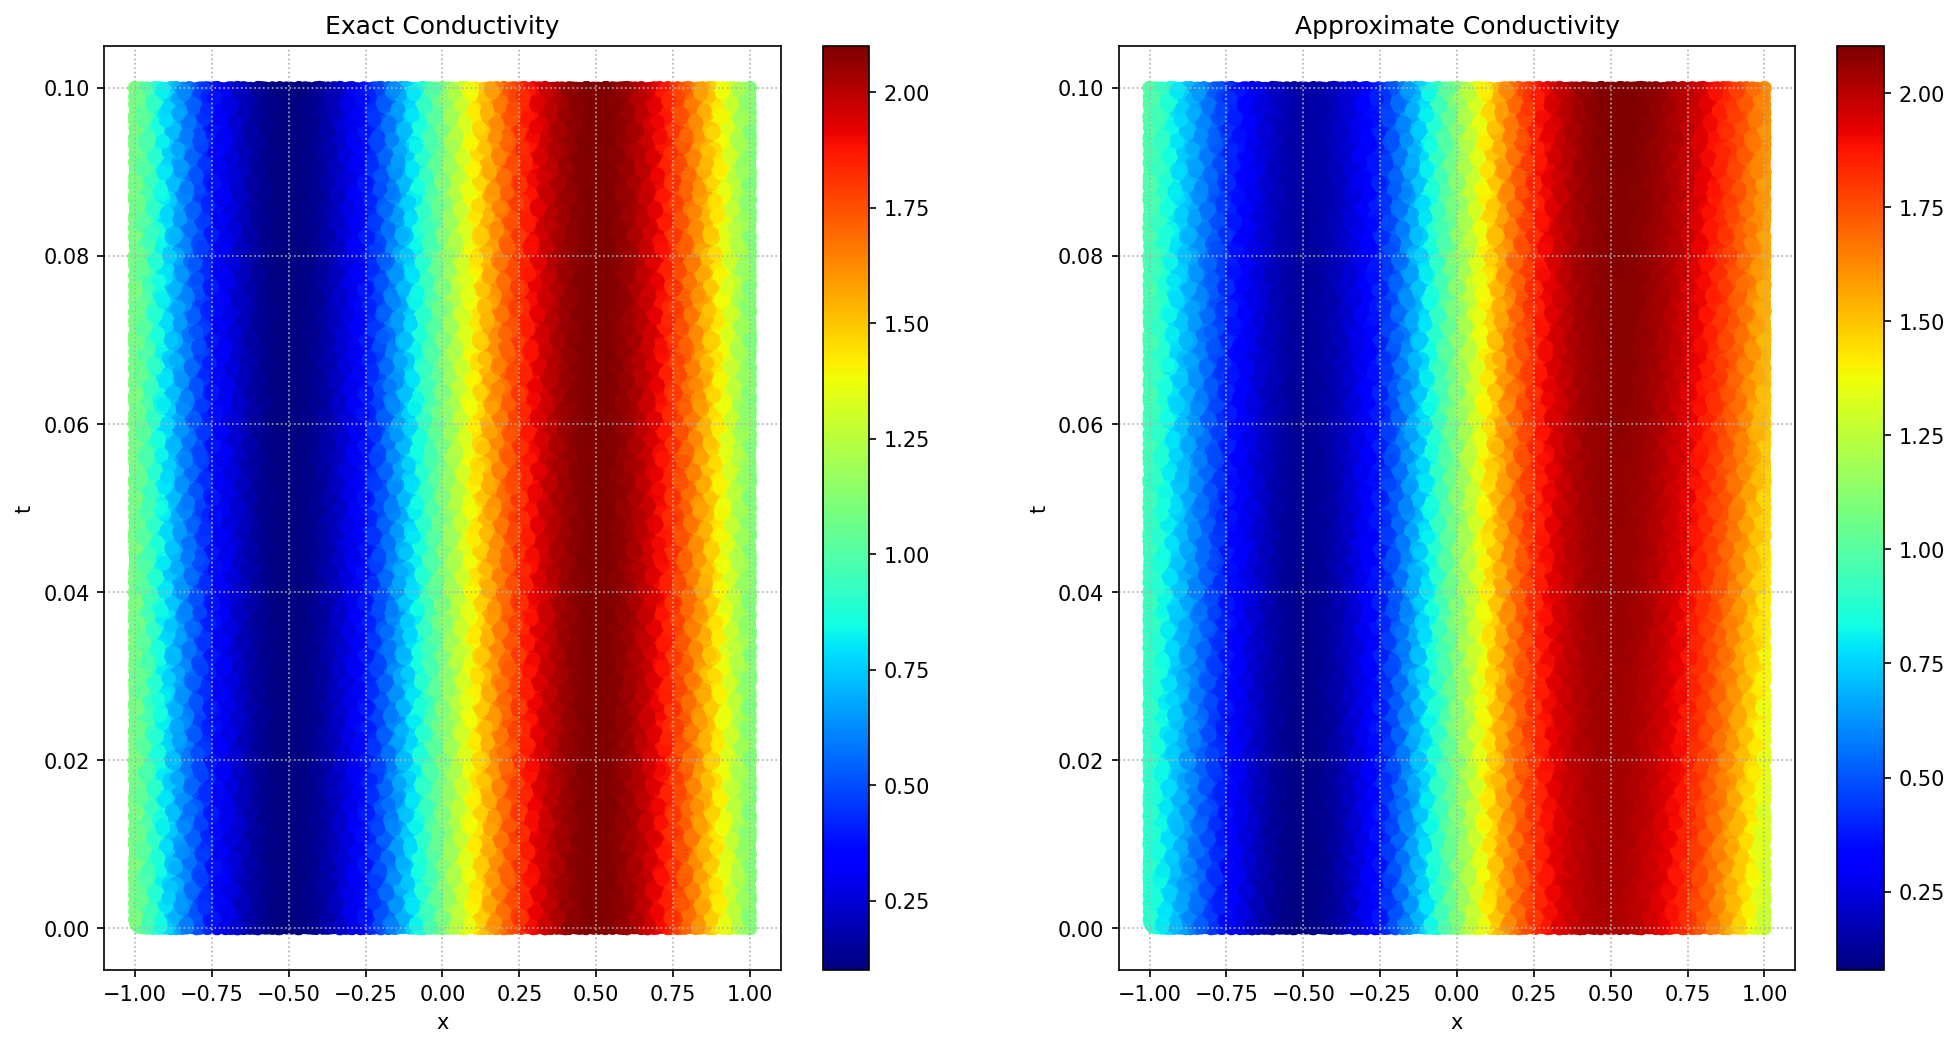

In [7]:
pinn.plotting()